# Kalsifikasi Hasil Pengelompokan Untuk DiPrediksi

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import pickle

# Model & Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Balancing Libraries
from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings('ignore')

print("Library siap. Pipeline Hybrid dengan 10-Fold Cross Validation.")

Library siap. Pipeline Hybrid dengan 10-Fold Cross Validation.


In [41]:
file_path = 'Hasil/KMeans_Result_K6.csv' 
if not os.path.exists(file_path):
    file_path = 'KMeans_Result_K6.csv'

df = pd.read_csv(file_path)

# 1. Siapkan Dataset
X = df[['Price_Cleaned', 'Seats_Cleaned']]
y = df['cluster']

# Ambil semua label unik
all_labels = np.unique(y)

print("Data dimuat.")
print(f"Total baris: {len(df)}")

Data dimuat.
Total baris: 1200


In [42]:
def hybrid_balancing(X_train, y_train):
    counts = y_train.value_counts()
    safe_threshold = 7 
    
    # STEP 1: ROS untuk data sangat sedikit
    ros_dict = {}
    need_ros = False
    for label, count in counts.items():
        if count < safe_threshold:
            ros_dict[label] = safe_threshold
            need_ros = True
            
    if need_ros:
        ros = RandomOverSampler(sampling_strategy=ros_dict, random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
    
    # STEP 2: SMOTE untuk variasi
    try:
        smote = SMOTE(k_neighbors=5, random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        return X_train_balanced, y_train_balanced
    except Exception:
        ros_full = RandomOverSampler(random_state=42)
        return ros_full.fit_resample(X_train, y_train)

print("Fungsi Balancing siap.")

Fungsi Balancing siap.


In [49]:
# UBAH JUMLAH FOLD DI SINI
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []
conf_matrices = []

# Variabel untuk menyimpan model juara
best_model = None
best_acc_score = 0.0
best_fold_index = 0

print(f"=== Memulai Training {n_splits}-Fold Stratified ===")
print("(Model dengan akurasi tertinggi akan disimpan otomatis)\n")

fold_no = 1
for train_idx, test_idx in skf.split(X, y):
    # Pisahkan Train dan Test
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Balancing (Train Only)
    X_train_bal, y_train_bal = hybrid_balancing(X_train, y_train)
    
    # Training
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_bal, y_train_bal)
    
    # Evaluasi
    y_pred = rf_model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred, labels=all_labels)
    
    acc_scores.append(acc)
    f1_scores.append(f1)
    conf_matrices.append(cm)
    
    print(f"Fold {fold_no}: Acc = {acc:.4f} | F1 = {f1:.4f}")
    
    # --- LOGIKA MENYIMPAN MODEL TERBAIK ---
    if acc > best_acc_score:
        best_acc_score = acc
        best_model = rf_model # Simpan model ini ke variabel
        best_fold_index = fold_no
    # --------------------------------------
    
    fold_no += 1

print(f"\nTraining Selesai.")
print(f"Rata-rata Accuracy: {np.mean(acc_scores):.4f}")
print(f"MODEL TERBAIK ditemukan pada Fold ke-{best_fold_index} dengan Akurasi: {best_acc_score:.4f}")

=== Memulai Training 5-Fold Stratified ===
(Model dengan akurasi tertinggi akan disimpan otomatis)

Fold 1: Acc = 1.0000 | F1 = 1.0000
Fold 2: Acc = 0.9958 | F1 = 0.7975
Fold 3: Acc = 1.0000 | F1 = 1.0000
Fold 4: Acc = 0.9958 | F1 = 0.7975
Fold 5: Acc = 0.9958 | F1 = 0.7600

Training Selesai.
Rata-rata Accuracy: 0.9975
MODEL TERBAIK ditemukan pada Fold ke-1 dengan Akurasi: 1.0000



=== HASIL AKHIR (RATA-RATA 10 FOLD) ===
• Average Accuracy : 0.9975
• Average F1-Macro : 0.9323


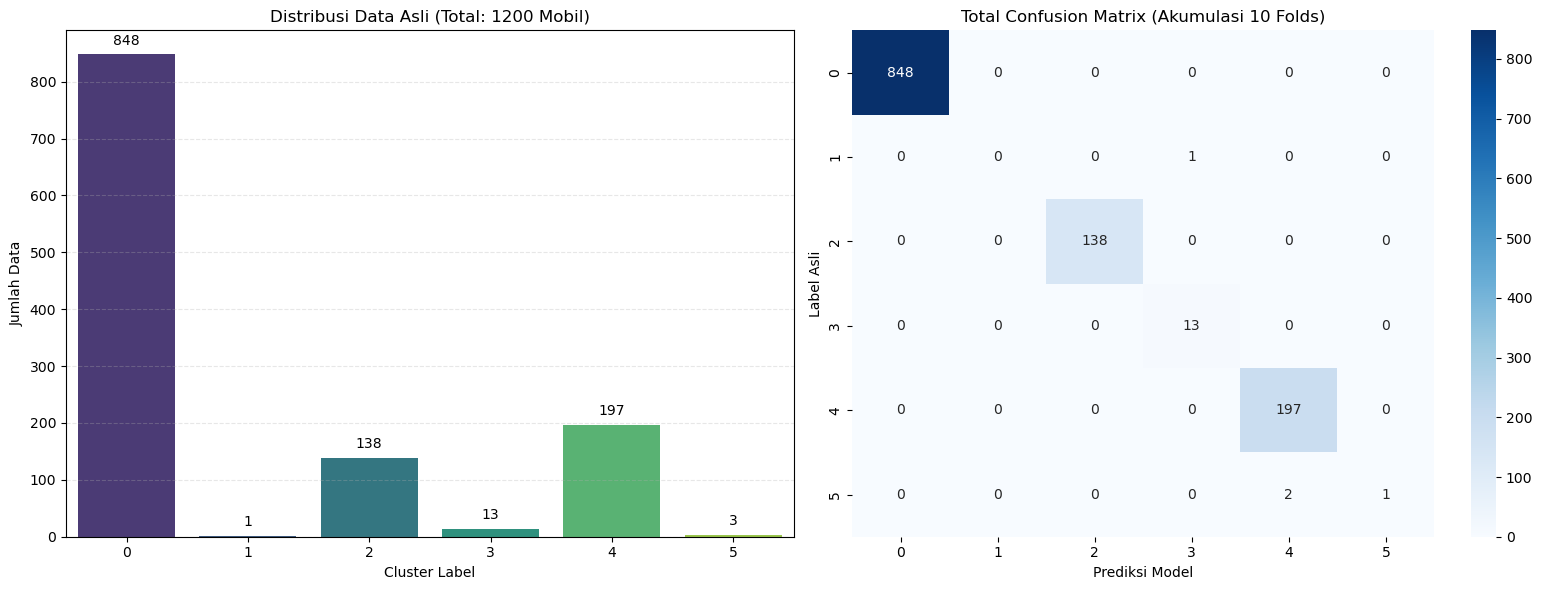

In [44]:
# Hitung Rata-rata
mean_acc = np.mean(acc_scores)
mean_f1 = np.mean(f1_scores)

print("\n=== HASIL AKHIR (RATA-RATA 10 FOLD) ===")
print(f"• Average Accuracy : {mean_acc:.4f}")
print(f"• Average F1-Macro : {mean_f1:.4f}")

# Agregasi Confusion Matrix
sum_cm = np.sum(conf_matrices, axis=0)

# Visualisasi
plt.figure(figsize=(16, 6))

# Grafik 1: Distribusi Data Asli
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x=y, palette='viridis')
plt.title(f"Distribusi Data Asli (Total: {len(y)} Mobil)")
plt.xlabel("Cluster Label")
plt.ylabel("Jumlah Data")
plt.grid(axis='y', linestyle='--', alpha=0.3)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Grafik 2: Total Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(sum_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=all_labels, yticklabels=all_labels)
plt.title(f'Total Confusion Matrix (Akumulasi {n_splits} Folds)')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')

plt.tight_layout()
plt.show()

In [51]:
import json
import pickle

print("=== MENYIAPKAN ASET MINI GAMES (TANPA RETRAIN) ===")

# 1. Cek apakah model terbaik ada
if best_model is None:
    raise ValueError("Error: Belum ada model yang terbentuk. Jalankan Cell 4 dulu!")

print(f"Menggunakan Model Terbaik dari Fold ke-{best_fold_index} (Akurasi: {best_acc_score:.4f})")

# 2. Buat Label Mapping Otomatis (Penamaan Keren)
# Kita tetap butuh statistik rata-rata untuk memberi nama
cluster_stats = df.groupby('cluster')[['Price_Cleaned', 'Seats_Cleaned']].mean()
label_mapping = {}

print("\n--- GENERATE NAMA LABEL ---")
for cluster_id, row in cluster_stats.iterrows():
    avg_price = row['Price_Cleaned']
    avg_seats = row['Seats_Cleaned']
    
    # Rule Penamaan (Bisa disesuaikan)
    category = "Standard"
    if avg_price > 150000: category = "Super Luxury"
    elif avg_price > 60000: category = "Premium"
    elif avg_price < 20000: category = "Budget"
        
    type_car = "Car"
    if avg_seats >= 6: type_car = "Family Van/MPV"
    elif avg_seats >= 4: type_car = "Sedan/SUV"
    elif avg_seats <= 2: type_car = "Sport/Coupe"
        
    label_name = f"{category} {type_car}"
    label_mapping[int(cluster_id)] = label_name
    
    print(f"Cluster {cluster_id} -> '{label_name}'")

# 3. Simpan Aset
output_dir = 'MiniGames_Assets'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Simpan Model (Pickle)
model_path = os.path.join(output_dir, 'car_prediction_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Simpan Label Map (JSON)
json_path = os.path.join(output_dir, 'cluster_labels.json')
with open(json_path, 'w') as f:
    json.dump(label_mapping, f, indent=4)

print("\n" + "="*50)
print("ASET TERSIMPAN!")
print(f"File Model : {model_path}")
print(f"File Label : {json_path}")
print("Siap digunakan untuk script game.")
print("="*50)

=== MENYIAPKAN ASET MINI GAMES (TANPA RETRAIN) ===
Menggunakan Model Terbaik dari Fold ke-1 (Akurasi: 1.0000)

--- GENERATE NAMA LABEL ---
Cluster 0 -> 'Premium Sedan/SUV'
Cluster 1 -> 'Super Luxury Sport/Coupe'
Cluster 2 -> 'Super Luxury Car'
Cluster 3 -> 'Super Luxury Sport/Coupe'
Cluster 4 -> 'Standard Family Van/MPV'
Cluster 5 -> 'Standard Family Van/MPV'

ASET TERSIMPAN!
File Model : MiniGames_Assets\car_prediction_model.pkl
File Label : MiniGames_Assets\cluster_labels.json
Siap digunakan untuk script game.
